In [8]:
# =================================================================================================
# CÉLULA 1: Importações e Funções Utilitárias
# =================================================================================================

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F

import os
import time
import gc
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

# --- Funções Utilitárias para Monitoramento ---

def format_bytes(n_bytes):
    """Formata um número de bytes para uma string legível (MB)."""
    return f"{n_bytes / 1024 / 1024:.1f} MB"

def gpu_mem_str():
    """Retorna uma string formatada com o uso de memória da GPU (se disponível)."""
    if not torch.cuda.is_available() or not torch.cuda.is_initialized():
        return "GPU: N/A"
    
    # Sincroniza para garantir que as medições estejam atualizadas
    torch.cuda.synchronize()
    
    # Coleta estatísticas de memória
    alloc = torch.cuda.memory_allocated()  # Memória atualmente alocada para tensores
    reserved = torch.cuda.memory_reserved() # Memória total reservada pelo PyTorch
    peak = torch.cuda.max_memory_allocated() # Pico de memória alocada desde o início
    
    return f"GPU Mem: Alocada={format_bytes(alloc)} | Reservada={format_bytes(reserved)} | Pico={format_bytes(peak)}"

In [9]:
# =================================================================================================
# CÉLULA 2: Transformações de Dados (CocoTransform)
# =================================================================================================

class CocoTransform:
    """
    Classe para aplicar transformações em imagens e suas anotações (alvos).
    É essencial para garantir que os dados de entrada estejam no formato correto.
    """
    def __init__(self, max_size=720):
        """
        Args:
            max_size (int): O tamanho máximo para o maior lado da imagem. 
                            Imagens maiores serão redimensionadas para este tamanho,
                            mantendo a proporção.
        """
        self.max_size = max_size

    def __call__(self, image, target):
        """
        Este método é chamado para cada amostra (imagem, anotação) pelo DataLoader.

        Args:
            image (PIL.Image): A imagem a ser transformada.
            target (list[dict]): Uma lista de dicionários, onde cada dicionário é uma anotação
                                 de objeto no formato COCO.

        Returns:
            tuple: Uma tupla contendo a imagem como um tensor e a lista de alvos processados.
        """
        # --- 1. Redimensionamento da Imagem ---
        orig_w, orig_h = image.size
        scale_factor = 1.0
        
        if self.max_size is not None:
            long_side = max(orig_w, orig_h)
            if long_side > self.max_size:
                scale_factor = self.max_size / long_side
                new_w = int(round(orig_w * scale_factor))
                new_h = int(round(orig_h * scale_factor))
                image = F.resize(image, [new_h, new_w])

        # --- 2. Processamento das Bounding Boxes ---
        # Esta é a correção crucial. As anotações devem ser processadas para CADA imagem.
        processed_annotations = []
        for obj in target:
            x, y, w, h = obj["bbox"]  # Formato COCO: [x_inicio, y_inicio, largura, altura]
            
            # Aplica o fator de escala do redimensionamento da imagem
            scaled_x = x * scale_factor
            scaled_y = y * scale_factor
            scaled_w = w * scale_factor
            scaled_h = h * scale_factor
            
            # Converte do formato COCO (XYWH) para o formato do modelo (XYXY)
            # Formato do modelo: [x_min, y_min, x_max, y_max]
            x1, y1 = scaled_x, scaled_y
            x2, y2 = scaled_x + scaled_w, scaled_y + scaled_h
            
            # Garante que a caixa tenha área válida (largura e altura > 0)
            if x2 > x1 and y2 > y1:
                # Atualiza a anotação com a caixa no formato correto
                obj["bbox"] = [x1, y1, x2, y2]
                processed_annotations.append(obj)
        
        # --- 3. Conversão para Tensor ---
        # Converte a imagem de formato PIL para um tensor PyTorch (C, H, W) com valores [0, 1]
        image_tensor = F.to_tensor(image)
        
        return image_tensor, processed_annotations

In [10]:
# =================================================================================================
# CÉLULA 3: Carregamento do Dataset e DataLoaders
# =================================================================================================

def get_coco_dataset(img_dir, ann_file, max_image_size=720):
    """Função auxiliar para criar um dataset COCO com a transformação."""
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform(max_size=max_image_size),
    )

# --- Caminhos para os dados ---
TRAIN_IMG_DIR = './new_whales_rcnn/images/Train'
TRAIN_ANN_FILE = './new_whales_rcnn/annotations/instances_Train.json'
VAL_IMG_DIR = './new_whales_rcnn/images/Validation'
VAL_ANN_FILE = './new_whales_rcnn/annotations/instances_Validation.json'

# --- Criação dos Datasets ---
train_dataset = get_coco_dataset(TRAIN_IMG_DIR, TRAIN_ANN_FILE, max_image_size=720)
val_dataset = get_coco_dataset(VAL_IMG_DIR, VAL_ANN_FILE, max_image_size=720)

# --- Verificação Crítica de Anotações ---
# Verifica se o arquivo de anotações de treino contém alguma anotação.
if not train_dataset.coco.getAnnIds():
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("!!! AVISO CRÍTICO: Seu arquivo 'instances_Train.json' não   !!!")
    print("!!! contém nenhuma anotação (bounding box). O modelo não    !!!")
    print("!!! aprenderá nada. Por favor, corrija suas anotações.      !!!")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

# --- Mapeamento de Classes ---
# Cria um mapa para converter os IDs de categoria do COCO (que podem não ser sequenciais)
# para IDs de rótulo sequenciais que o modelo espera (ex: 1, 2, 3...).
# O rótulo 0 é reservado para o "fundo" (background).
cat_ids = sorted(train_dataset.coco.getCatIds())
label_map = {cat_id: i + 1 for i, cat_id in enumerate(cat_ids)}
num_classes = len(label_map) + 1  # Número de classes + 1 para o fundo

# Dicionários para visualização (mapeia ID para nome da classe)
catid_to_name = {cat_id: train_dataset.coco.cats[cat_id]["name"] for cat_id in cat_ids}
label_to_name = {label: catid_to_name[cat_id] for cat_id, label in label_map.items()}

print(f"Número de classes detectadas: {len(label_map)} (total com fundo: {num_classes})")
print(f"Mapeamento de classes: {label_to_name}")

# --- Criação dos DataLoaders ---
# O collate_fn é necessário porque as imagens no lote podem ter tamanhos diferentes
# após o redimensionamento, e esta função as agrupa corretamente.
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=2,  # Aumente se sua GPU permitir (ex: 4, 8)
    shuffle=True,
    num_workers=2, # Aumente para acelerar o carregamento de dados
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Número de classes detectadas: 1 (total com fundo: 2)
Mapeamento de classes: {1: 'whale'}


In [11]:
# =================================================================================================
# CÉLULA 4: Definição do Modelo
# =================================================================================================

def get_model(num_classes):
    """
    Carrega um modelo Faster R-CNN pré-treinado no dataset COCO e o adapta
    para o nosso número de classes.
    """
    # 1. Carrega o modelo pré-treinado
    model = fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # 2. Obtém o número de características de entrada do classificador de caixas
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 3. Substitui a "cabeça" do classificador por uma nova, compatível com nosso número de classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# --- Instanciação do Modelo e Otimizador ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_classes)
model.to(device)

# Configura o otimizador (SGD é um padrão robusto para detecção de objetos)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# Configura o agendador de taxa de aprendizado (reduz o LR ao longo do tempo para estabilizar o treino)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [12]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, label_map, print_every=50):
    """Executa uma única época de treinamento."""
    model.train()  # Coloca o modelo em modo de treino
    start_t = time.time()
    if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()

    running_loss, steps = 0.0, 0
    
    for i, (images, targets) in enumerate(data_loader, 1):
        images = [img.to(device) for img in images]

        # --- Lógica de Processamento de Alvos (CORRIGIDA) ---
        # O modelo espera um alvo para CADA imagem, mesmo que esteja vazio.
        processed_targets = []
        has_any_target = False
        for target_list in targets:
            boxes, labels = [], []
            for obj in target_list:
                label = label_map.get(obj["category_id"])
                if label is not None:
                    boxes.append(obj["bbox"])
                    labels.append(label)
            
            # --- CORREÇÃO DO ERRO DE SHAPE ---
            # Se 'boxes' estiver vazio, cria um tensor com shape [0, 4].
            # Caso contrário, cria o tensor a partir da lista de caixas.
            if boxes:
                boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
                has_any_target = True
            else:
                boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            # --- FIM DA CORREÇÃO ---

            processed_targets.append({
                "boxes": boxes_tensor.to(device),
                "labels": torch.tensor(labels, dtype=torch.int64).to(device),
            })
        
        # Pula o lote se NENHUMA imagem tiver anotações
        if not has_any_target:
            if i % print_every == 0: print(f"[Época {epoch}][{i}/{len(data_loader)}] Lote pulado (sem alvos válidos).")
            continue

        # --- Forward e Backward Pass ---
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        if torch.isnan(losses):
            print(f"[Época {epoch}][{i}/{len(data_loader)}] Perda é NaN. Pulando lote.")
            continue

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        steps += 1

        if i % print_every == 0 and steps > 0:
            print(f"[Época {epoch}][{i}/{len(data_loader)}] Perda Média: {running_loss/steps:.4f} | {gpu_mem_str()}")

    # --- Fim da Época ---
    avg_epoch_loss = running_loss / steps if steps > 0 else float('nan')
    print(f"Fim da Época {epoch}: Perda Média = {avg_epoch_loss:.4f} | Duração: {time.time() - start_t:.1f}s")
    return avg_epoch_loss

def show_predictions(model, device, label_to_name, n_images=4, score_thresh=0.5):
    """Executa inferência em imagens de validação e as exibe."""
    model.eval()
    
    # Pega um lote aleatório do loader de validação
    try:
        images, _ = next(iter(val_loader))
    except StopIteration:
        print("Não foi possível obter imagens do loader de validação.")
        return

    images_for_pred = [img.to(device) for img in images[:n_images]]
    
    with torch.no_grad():
        predictions = model(images_for_pred)

    # Prepara para plotagem
    fig, axes = plt.subplots(1, len(images_for_pred), figsize=(20, 10))
    if len(images_for_pred) == 1: axes = [axes]

    print(f"Exibindo previsões com limiar de score >= {score_thresh}")
    for img_tensor, pred, ax in zip(images_for_pred, predictions, axes):
        img_display = img_tensor.cpu().permute(1, 2, 0).numpy()
        ax.imshow(img_display)
        ax.axis("off")

        for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
            if score >= score_thresh:
                x1, y1, x2, y2 = box.cpu().numpy()
                class_name = label_to_name.get(label.item(), "Desconhecido")
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1 - 10, f"{class_name}: {score:.2f}", color='white', bbox={'facecolor': 'red', 'alpha': 0.8})
    
    plt.tight_layout()
    plt.show()

--- Fim da Época 15/15 ---


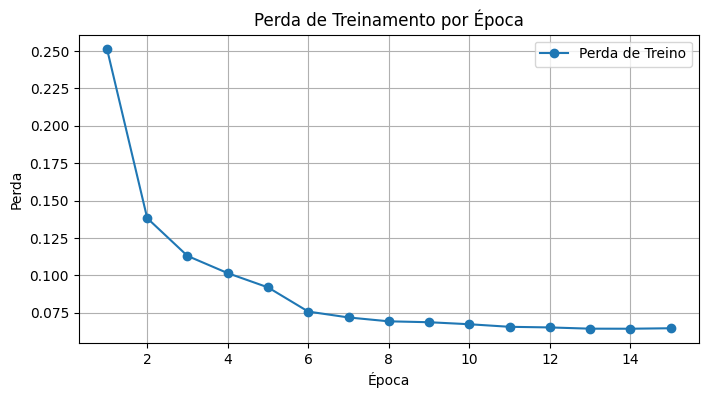

Exibindo previsões com limiar de score >= 0.3


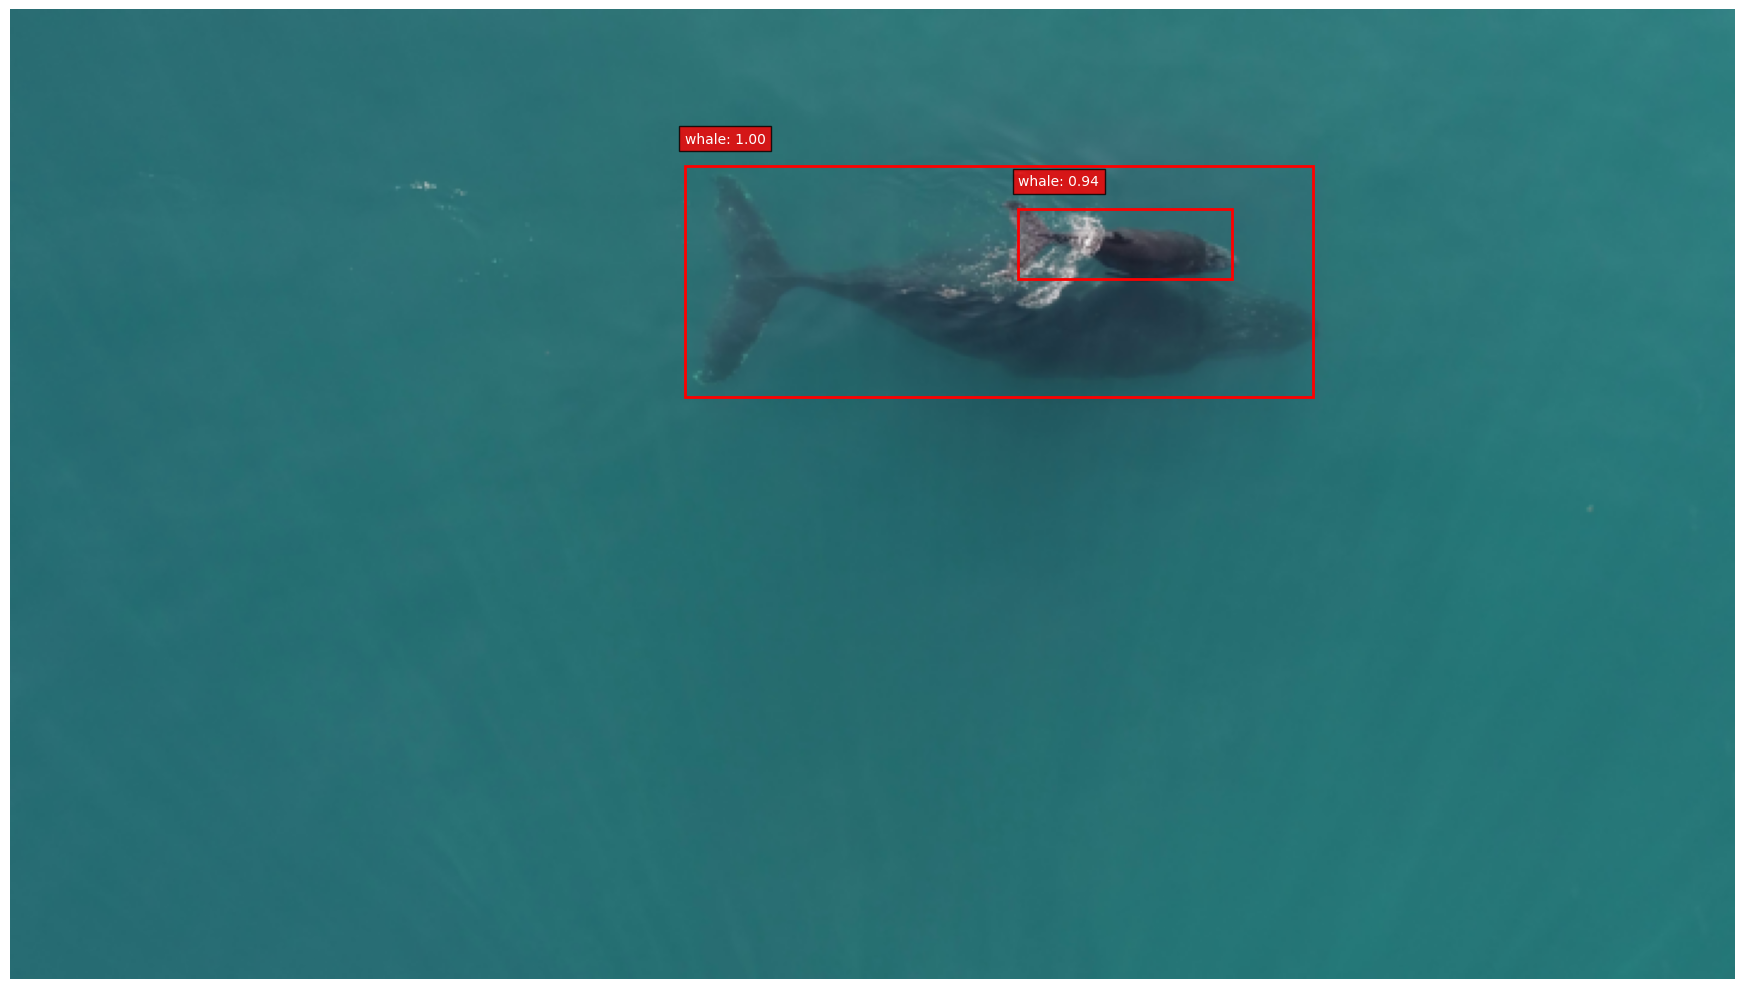

Recursos da GPU liberados.


In [13]:
# =================================================================================================
# CÉLULA 6: Loop de Treinamento Principal
# =================================================================================================

num_epochs = 15
train_losses = []

try:
    for epoch in range(num_epochs):
        # 1. Treina uma época
        avg_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, label_map)
        train_losses.append(avg_loss)
        
        # 2. Atualiza a taxa de aprendizado
        lr_scheduler.step()

        # 3. Salva o checkpoint do modelo
        torch.save(model.state_dict(), f"fasterrcnn_epoch_{epoch+1}.pth")

        # --- Visualização Periódica ---
        # Limpa a saída da célula para mostrar as novas imagens
        clear_output(wait=True)
        
        print(f"--- Fim da Época {epoch+1}/{num_epochs} ---")
        
        # Mostra o gráfico de perda atualizado
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Perda de Treino')
        plt.title("Perda de Treinamento por Época")
        plt.xlabel("Época")
        plt.ylabel("Perda")
        plt.grid(True)
        plt.legend()
        plt.show()
        
        # Mostra as previsões no conjunto de validação
        show_predictions(model, device, label_to_name, n_images=2, score_thresh=0.3)

finally:
    # Garante a liberação de memória da GPU ao final
    try:
        model.to('cpu')
        del model, optimizer, lr_scheduler
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print("Recursos da GPU liberados.")
    except Exception as e:
        print(f"Erro ao liberar recursos: {e}")

In [20]:
# =================================================================================================
# CÉLULA 7: Pipeline de Avaliação Completa (CORRIGIDA)
# =================================================================================================
import glob
import pandas as pd
from torchvision.ops import box_iou

def calculate_metrics_for_model(model, data_loader, device, iou_threshold=0.5, score_threshold=0.5):
    """
    Calcula Precision, Recall e F1-Score para um modelo em um dataset.
    """
    model.eval()
    
    total_tp, total_fp, total_fn = 0, 0, 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            for i in range(len(images)):
                pred_boxes = predictions[i]['boxes']
                pred_scores = predictions[i]['scores']
                pred_labels = predictions[i]['labels']
                
                gt_boxes = [obj['bbox'] for obj in targets[i]] if targets[i] else []
                gt_labels = [label_map[obj['category_id']] for obj in targets[i]] if targets[i] else []
                
                # Converte ground truth para tensores se não estiverem vazios
                if gt_boxes:
                    # --- CORREÇÃO APLICADA AQUI ---
                    # Move os tensores de anotação para o mesmo dispositivo do modelo (GPU).
                    gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32).to(device)
                    gt_labels = torch.tensor(gt_labels, dtype=torch.int64).to(device)
                    # --- FIM DA CORREÇÃO ---
                else: 
                    total_fp += len(pred_scores[pred_scores >= score_threshold])
                    continue

                # Filtra previsões pelo limiar de score
                high_conf_preds_mask = pred_scores >= score_threshold
                pred_boxes = pred_boxes[high_conf_preds_mask]
                pred_labels = pred_labels[high_conf_preds_mask]

                if pred_boxes.shape[0] == 0: 
                    total_fn += gt_boxes.shape[0]
                    continue

                # Matriz de IoU entre previsões e anotações (agora ambos na GPU)
                iou_matrix = box_iou(pred_boxes, gt_boxes)
                
                matches = []
                if iou_matrix.numel() > 0:
                    max_iou_per_gt, max_iou_indices = iou_matrix.max(dim=0)
                    
                    for gt_idx, (iou, pred_idx) in enumerate(zip(max_iou_per_gt, max_iou_indices)):
                        if iou >= iou_threshold and pred_labels[pred_idx] == gt_labels[gt_idx]:
                            if pred_idx not in [m[0] for m in matches]:
                                # --- CORREÇÃO APLICADA AQUI ---
                                # gt_idx já é um int, não precisa de .item()
                                matches.append((pred_idx.item(), gt_idx))
                                # --- FIM DA CORREÇÃO ---

                tp = len(matches)
                fp = pred_boxes.shape[0] - tp
                fn = gt_boxes.shape[0] - tp
                
                total_tp += tp
                total_fp += fp
                total_fn += fn

    # Calcula as métricas finais
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "TP": total_tp,
        "FP": total_fp,
        "FN": total_fn
    }

# --- Configuração do Teste ---
TEST_IMG_DIR = './new_whales_rcnn/images/Test'
TEST_ANN_FILE = './new_whales_rcnn/annotations/instances_Test.json'

# Verifica se o dataset de teste existe
if not os.path.exists(TEST_ANN_FILE):
    print(f"AVISO: Arquivo de anotações de teste não encontrado em '{TEST_ANN_FILE}'. Pulando avaliação.")
else:
    # Cria o DataLoader de Teste
    test_dataset = get_coco_dataset(TEST_IMG_DIR, TEST_ANN_FILE)
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

    # Encontra todos os modelos salvos
    model_paths = sorted(glob.glob("fasterrcnn_epoch_*.pth"), key=lambda x: int(x.split('_')[-1].split('.')[0]))
    
    if not model_paths:
        print("Nenhum modelo (.pth) encontrado para avaliação.")
    else:
        results = []
        # Instancia o modelo uma vez
        eval_model = get_model(num_classes).to(device)

        for path in model_paths:
            print(f"Avaliando modelo: {path}...")
            eval_model.load_state_dict(torch.load(path))
            
            # Calcula as métricas com limiar de score de 0.5
            metrics = calculate_metrics_for_model(eval_model, test_loader, device, score_threshold=0.5)
            metrics['Model'] = path
            results.append(metrics)

        # Exibe os resultados em uma tabela
        if results:
            df = pd.DataFrame(results)
            df = df[['Model', 'Precision', 'Recall', 'F1-Score', 'TP', 'FP', 'FN']] # Reordena colunas
            df = df.sort_values(by="F1-Score", ascending=False)
            
            # --- CORREÇÃO DE FORMATAÇÃO DA TABELA ---
            # Define a formatação para 4 casas decimais para melhor legibilidade
            pd.set_option('display.float_format', '{:.4f}'.format)
            
            print("\n--- Tabela Comparativa de Resultados (Score Threshold=0.5, IoU Threshold=0.5) ---")
            print(df.to_string(index=False))
            
            # Reseta a opção de formatação para o padrão para não afetar outras células
            pd.reset_option('display.float_format')
# Limpa a memória
try:
    del eval_model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
except NameError:
    pass

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Avaliando modelo: fasterrcnn_epoch_1.pth...
Avaliando modelo: fasterrcnn_epoch_2.pth...
Avaliando modelo: fasterrcnn_epoch_3.pth...
Avaliando modelo: fasterrcnn_epoch_4.pth...
Avaliando modelo: fasterrcnn_epoch_5.pth...
Avaliando modelo: fasterrcnn_epoch_6.pth...
Avaliando modelo: fasterrcnn_epoch_7.pth...
Avaliando modelo: fasterrcnn_epoch_8.pth...
Avaliando modelo: fasterrcnn_epoch_9.pth...
Avaliando modelo: fasterrcnn_epoch_10.pth...
Avaliando modelo: fasterrcnn_epoch_11.pth...
Avaliando modelo: fasterrcnn_epoch_12.pth...
Avaliando modelo: fasterrcnn_epoch_13.pth...
Avaliando modelo: fasterrcnn_epoch_14.pth...
Avaliando modelo: fasterrcnn_epoch_15.pth...

--- Tabela Comparativa de Resultados (Score Threshold=0.5, IoU Threshold=0.5) ---
                  Model  Precision  Recall  F1-Score  TP  FP  FN
fasterrcnn_epoch_15.pth     0.8043  0.8706    0.8362  74  18  11
fasterrcnn_epoch_13.pth     0.8043  0.